# Spring 2025 Final Project

You are tasked to identify employees who are expected to leave from the company. You are given the past data but unfortunately it does not have the labels. 

But John who has been here for a long long time can help you out. You can ask him for a limited number of times. 

__NOTE:__ Do NOT use this notebook as your project template. You can copy & paste items such as the class below into your notebook.


__Data:__

`https://raw.githubusercontent.com/msaricaumbc/DS_data/master/ds602/final/employee_departure_dataset_X.csv` 


Create your solution as a notebook and save your final model.

## Employee Departure Prediction
### Problem Statement
Predict which employees are likely to leave the company using historical data and limited SME input.

In [37]:
import pandas as pd
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.expand_frame_repr', False)  # Prevent wrapping to multiple lines
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import silhouette_score
from sklearn.metrics import classification_report, roc_auc_score, f1_score
from sklearn.feature_selection import SelectFromModel
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline as make_imb_pipeline
from sklearn.cluster import KMeans
import joblib
import warnings
warnings.filterwarnings('ignore')

In [4]:
import pandas as pd

class SME():
    
    def __init__(self):
        self.asked = 0
        self.df = self.get()
        
    def get(self):
        X_train = pd.read_csv('https://raw.githubusercontent.com/msaricaumbc/DS_data/master/ds602/final/employee_departure_dataset_X.csv')
        y_train = pd.read_csv('https://raw.githubusercontent.com/msaricaumbc/DS_data/master/ds602/final/employee_departure_dataset_y.csv')

        X_train['Left'] = y_train
        return X_train
    
    def ask(self, valuedict):
        self.asked += 1
        #  print(self.asked)
        
        if self.asked > 500:
            raise Exception("Sorry, you have asked enough")

        arr = []
        for prop in valuedict:
            val = valuedict[prop]

            if val is None: 
                continue

            val = f"'{val}'" if isinstance(val,str) else val
            # print(prop, val)
            arr.append(f'{prop} == {val}')

            query = ' and '.join(arr)
        result = self.df.query(query)

        if len(result) == 0:
            raise Exception("I don't know")
        
        return (int)(result['Left'].mean())

sme = SME()

## Load and Inspect Data

In [6]:
df = sme.df.copy()

print("Initial data shape:", df.shape)
print("\nFirst 5 rows:")
display(df.head())

print(f"Dataset shape: {df.shape}")
print("\nData types:")
print(df.dtypes)
print("\nDataframe Info:")
print(df.info())
print("\nMissing values:")
print(df.isnull().sum())
df.describe()

Initial data shape: (500000, 28)

First 5 rows:


,RecordId,Gender,Distance,YearsWorked,TrainingHours,WorkLifeBalance,NumOfProjects,JobInvolvement,TeamSize,MentorshipReceived,TechSkillLevel,AttendanceRate,StressLevel,PeerFeedbackScore,AnnualLeaveDays,Certifications,SkillDevelopmentCourses,ProjectComplexity,WorkSatisfactionScore,JobEngagementScore,PhysicalActivityScore,MentalWellbeingScore,DepartmentCode,PreviousSalary,Salary,SelfReview,SupervisorReview,Left
0,100,1,>30miles,7,91,4,14,3,8,1,2,94.824162,3,2,3,0,0,2,3,2,9,5,5,72K,73K,4.0,4.0,0
1,101,0,~10miles,10,52,5,9,2,10,0,2,95.117962,4,5,4,0,0,1,3,4,8,1,1,62K,64K,4.0,4.0,0
2,102,0,~10miles,10,80,3,13,3,16,0,2,80.556119,1,1,2,1,0,3,7,2,7,8,5,73K,74K,4.0,2.0,1
3,103,0,~15miles,5,6,3,15,5,16,0,3,90.532289,1,1,21,1,1,4,6,9,5,5,1,63K,64K,5.0,5.0,0
4,104,1,~10miles,10,3,2,13,3,18,0,3,83.009190,3,3,16,1,0,3,3,4,4,4,2,60K,64K,4.0,4.0,0


Dataset shape: (500000, 28)

Data types:
RecordId                     int64
Gender                       int64
Distance                    object
YearsWorked                  int64
TrainingHours                int64
WorkLifeBalance              int64
NumOfProjects                int64
JobInvolvement               int64
TeamSize                     int64
MentorshipReceived           int64
TechSkillLevel               int64
AttendanceRate             float64
StressLevel                  int64
PeerFeedbackScore            int64
AnnualLeaveDays              int64
Certifications               int64
SkillDevelopmentCourses      int64
ProjectComplexity            int64
WorkSatisfactionScore        int64
JobEngagementScore           int64
PhysicalActivityScore        int64
MentalWellbeingScore         int64
DepartmentCode               int64
PreviousSalary              object
Salary                      object
SelfReview                 float64
SupervisorReview           float64
Left          

,RecordId,Gender,YearsWorked,TrainingHours,WorkLifeBalance,NumOfProjects,JobInvolvement,TeamSize,MentorshipReceived,TechSkillLevel,AttendanceRate,StressLevel,PeerFeedbackScore,AnnualLeaveDays,Certifications,SkillDevelopmentCourses,ProjectComplexity,WorkSatisfactionScore,JobEngagementScore,PhysicalActivityScore,MentalWellbeingScore,DepartmentCode,SelfReview,SupervisorReview,Left
count,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.00000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,498958.000000,499005.000000,500000.000000
mean,250099.500000,0.401232,7.002552,49.483502,3.002836,10.007036,2.996948,9.998880,0.50067,2.999154,89.995120,3.002938,3.001480,14.507630,2.001654,0.499882,3.001772,4.997358,4.995824,4.996368,5.003052,3.999612,4.399968,4.096981,0.360922
std,144337.711634,0.490148,1.868050,28.866048,1.413991,5.478671,1.414536,5.479373,0.50000,1.414082,5.777631,1.414613,1.413698,8.655087,1.414642,0.500000,1.413426,2.583222,2.582022,2.579361,2.580972,2.161918,0.663515,0.945597,0.480268
min,100.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.00000,1.000000,80.000028,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.000000,2.000000,0.000000
25%,125099.750000,0.000000,6.000000,24.000000,2.000000,5.000000,2.000000,5.000000,0.00000,2.000000,84.987994,2.000000,2.000000,7.000000,1.000000,0.000000,2.000000,3.000000,3.000000,3.000000,3.000000,2.000000,4.000000,4.000000,0.000000
50%,250099.500000,0.000000,7.000000,50.000000,3.000000,10.000000,3.000000,10.000000,1.00000,3.000000,89.988886,3.000000,3.000000,15.000000,2.000000,0.000000,3.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,4.000000,0.000000
75%,375099.250000,1.000000,8.000000,74.000000,4.000000,15.000000,4.000000,15.000000,1.00000,4.000000,94.998259,4.000000,4.000000,22.000000,3.000000,1.000000,4.000000,7.000000,7.000000,7.000000,7.000000,6.000000,5.000000,5.000000,1.000000
max,500099.000000,1.000000,14.000000,99.000000,5.000000,19.000000,5.000000,19.000000,1.00000,5.000000,99.999971,5.000000,5.000000,29.000000,4.000000,1.000000,5.000000,9.000000,9.000000,9.000000,9.000000,7.000000,5.000000,5.000000,1.000000


## Data Cleaning

In [11]:
def clean_data(df):
    """Perform data cleaning and preprocessing."""
    # Make a copy to avoid modifying original
    df = df.copy()
    
    # Convert salary to numeric (remove 'K' and convert to integer)
    df['PreviousSalary'] = df['PreviousSalary'].str.replace('K', '').astype(int)
    df['Salary'] = df['Salary'].str.replace('K', '').astype(int)
    
    # Handle missing values if any
    if df.isnull().sum().sum() > 0:
        print("Missing values found. Handling them...")
        # Fill numerical missing values with median
        num_cols = df.select_dtypes(include=np.number).columns
        for col in num_cols:
            df[col].fillna(df[col].median(), inplace=True)
        
        # Fill categorical missing values with mode
        cat_cols = df.select_dtypes(exclude=np.number).columns
        for col in cat_cols:
            df[col].fillna(df[col].mode()[0], inplace=True)

    #Drop RecordId isnce it is unique
    df.drop(['RecordId'], axis=1, inplace=True)
    
    return df

cleaned_data = clean_data(df)
print("\nAfter cleaning:")
print("Missing values:", cleaned_data.isnull().sum().sum())
display(cleaned_data.head())

Missing values found. Handling them...

After cleaning:
Missing values: 0


,Gender,Distance,YearsWorked,TrainingHours,WorkLifeBalance,NumOfProjects,JobInvolvement,TeamSize,MentorshipReceived,TechSkillLevel,AttendanceRate,StressLevel,PeerFeedbackScore,AnnualLeaveDays,Certifications,SkillDevelopmentCourses,ProjectComplexity,WorkSatisfactionScore,JobEngagementScore,PhysicalActivityScore,MentalWellbeingScore,DepartmentCode,PreviousSalary,Salary,SelfReview,SupervisorReview,Left
0,1,>30miles,7,91,4,14,3,8,1,2,94.824162,3,2,3,0,0,2,3,2,9,5,5,72,73,4.0,4.0,0
1,0,~10miles,10,52,5,9,2,10,0,2,95.117962,4,5,4,0,0,1,3,4,8,1,1,62,64,4.0,4.0,0
2,0,~10miles,10,80,3,13,3,16,0,2,80.556119,1,1,2,1,0,3,7,2,7,8,5,73,74,4.0,2.0,1
3,0,~15miles,5,6,3,15,5,16,0,3,90.532289,1,1,21,1,1,4,6,9,5,5,1,63,64,5.0,5.0,0
4,1,~10miles,10,3,2,13,3,18,0,3,83.009190,3,3,16,1,0,3,3,4,4,4,2,60,64,4.0,4.0,0


### Cleaning Documentation:
1. **Salary Conversion**: Converted '50K' format to numeric 50
2. **Missing Values**: Checked and handled any missing values
3. **Data Types**: Ensured proper data types for all columns
4. **Target Integration**: Combined features with target variable

## Feature Engineering

In [15]:
def engineer_features(df):
    """Create new features from existing data."""
    df = df.copy()
    
    # Salary features
    df['Increment'] = df['Salary'] - df['PreviousSalary']
    df['IncrementPerc'] = (df['Increment'] / df['PreviousSalary']) * 100
    
    # Productivity features
    df['ProjectsPerYear'] = df['NumOfProjects'] / (df['YearsWorked'] + 1)
    df['TrainingPerProject'] = df['TrainingHours'] / (df['NumOfProjects'] + 1)
    
    # Work-life features
    df['WorkLifeScore'] = df['WorkLifeBalance'] * df['MentalWellbeingScore']
    
    # Engagement features
    df['EngagementRatio'] = df['JobEngagementScore'] / df['WorkSatisfactionScore']

    #Certification features
    df['CertificationsPerYear'] = df['Certifications'] / (df['YearsWorked'] + 1)

    #Rating features
    df['ReviewDiff'] = df['SelfReview'] - df['SupervisorReview']

    #Actual Days Worked
    df['ExtraLeaves'] = 260 * (1 - (df['AttendanceRate'] / 100)) - df['AnnualLeaveDays']
    
    return df

engineered_data = engineer_features(cleaned_data)
print("\nAfter Feature Engineering:")
display(engineered_data.head())


After Feature Engineering:


,Gender,Distance,YearsWorked,TrainingHours,WorkLifeBalance,NumOfProjects,JobInvolvement,TeamSize,MentorshipReceived,TechSkillLevel,AttendanceRate,StressLevel,PeerFeedbackScore,AnnualLeaveDays,Certifications,SkillDevelopmentCourses,ProjectComplexity,WorkSatisfactionScore,JobEngagementScore,PhysicalActivityScore,MentalWellbeingScore,DepartmentCode,PreviousSalary,Salary,SelfReview,SupervisorReview,Left,Increment,IncrementPerc,ProjectsPerYear,TrainingPerProject,WorkLifeScore,EngagementRatio,CertificationsPerYear,ReviewDiff,ExtraLeaves
0,1,>30miles,7,91,4,14,3,8,1,2,94.824162,3,2,3,0,0,2,3,2,9,5,5,72,73,4.0,4.0,0,1,1.388889,1.750000,6.066667,20,0.666667,0.000000,0.0,10.457179
1,0,~10miles,10,52,5,9,2,10,0,2,95.117962,4,5,4,0,0,1,3,4,8,1,1,62,64,4.0,4.0,0,2,3.225806,0.818182,5.200000,5,1.333333,0.000000,0.0,8.693299
2,0,~10miles,10,80,3,13,3,16,0,2,80.556119,1,1,2,1,0,3,7,2,7,8,5,73,74,4.0,2.0,1,1,1.369863,1.181818,5.714286,24,0.285714,0.090909,2.0,48.554090
3,0,~15miles,5,6,3,15,5,16,0,3,90.532289,1,1,21,1,1,4,6,9,5,5,1,63,64,5.0,5.0,0,1,1.587302,2.500000,0.375000,15,1.500000,0.166667,0.0,3.616048
4,1,~10miles,10,3,2,13,3,18,0,3,83.009190,3,3,16,1,0,3,3,4,4,4,2,60,64,4.0,4.0,0,4,6.666667,1.181818,0.214286,8,1.333333,0.090909,0.0,28.176106


### Feature Engineering Documentation:
1. **Salary Features**: Calculated absolute and percentage salary increases
2. **Productivity Metrics**: Projects per year and training per project ratios
3. **Wellbeing Metrics**: Combined work-life balance with mental wellbeing
4. **Engagement Metrics**: Ratio between job engagement and satisfaction
5. **Certification Metrics**: Certifications per year
6. **Rating Features**: Rating Difference between Self Review and Supervisor Review


## Exploratory Data Analysis (EDA)

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier

# Set style for plots
sns.set(style="whitegrid")

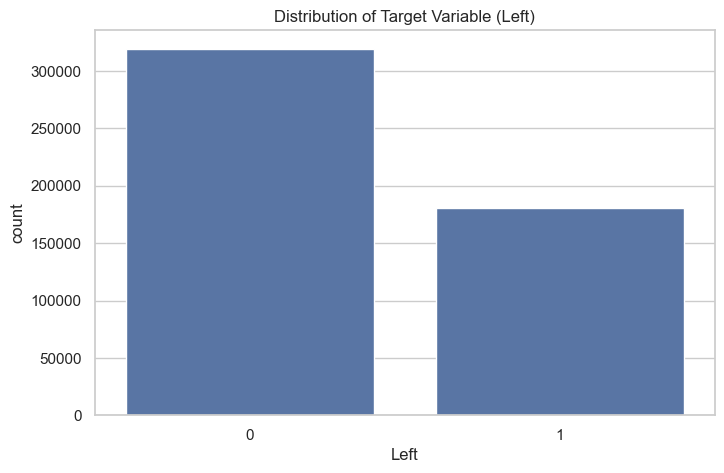

Class Balance:
Left
0    0.639078
1    0.360922
Name: proportion, dtype: float64


In [20]:
### 1. Target Variable Distribution
plt.figure(figsize=(8,5))
sns.countplot(x='Left', data=cleaned_data)
plt.title('Distribution of Target Variable (Left)')
plt.show()

print("Class Balance:")
print(cleaned_data['Left'].value_counts(normalize=True))

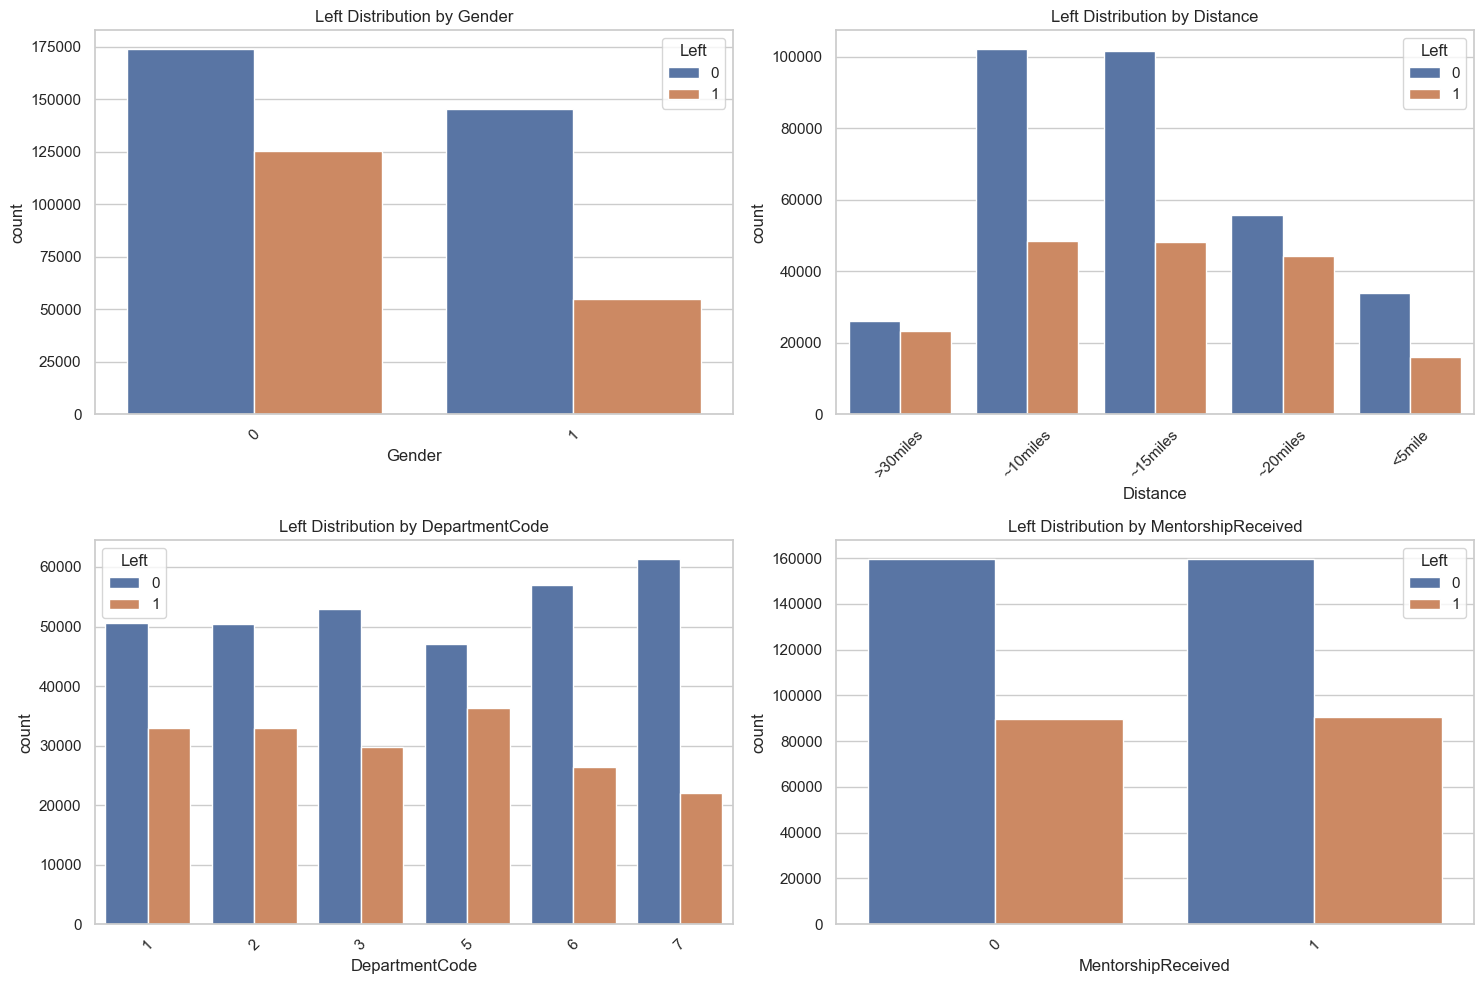

In [21]:
## 2. Target Distribution Across Categorical Features
# Plot for categorical features
cat_features = ['Gender', 'Distance', 'DepartmentCode', 'MentorshipReceived']

plt.figure(figsize=(15,10))
for i, feature in enumerate(cat_features, 1):
    plt.subplot(2, 2, i)
    sns.countplot(x=feature, hue='Left', data=cleaned_data)
    plt.title(f'Left Distribution by {feature}')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

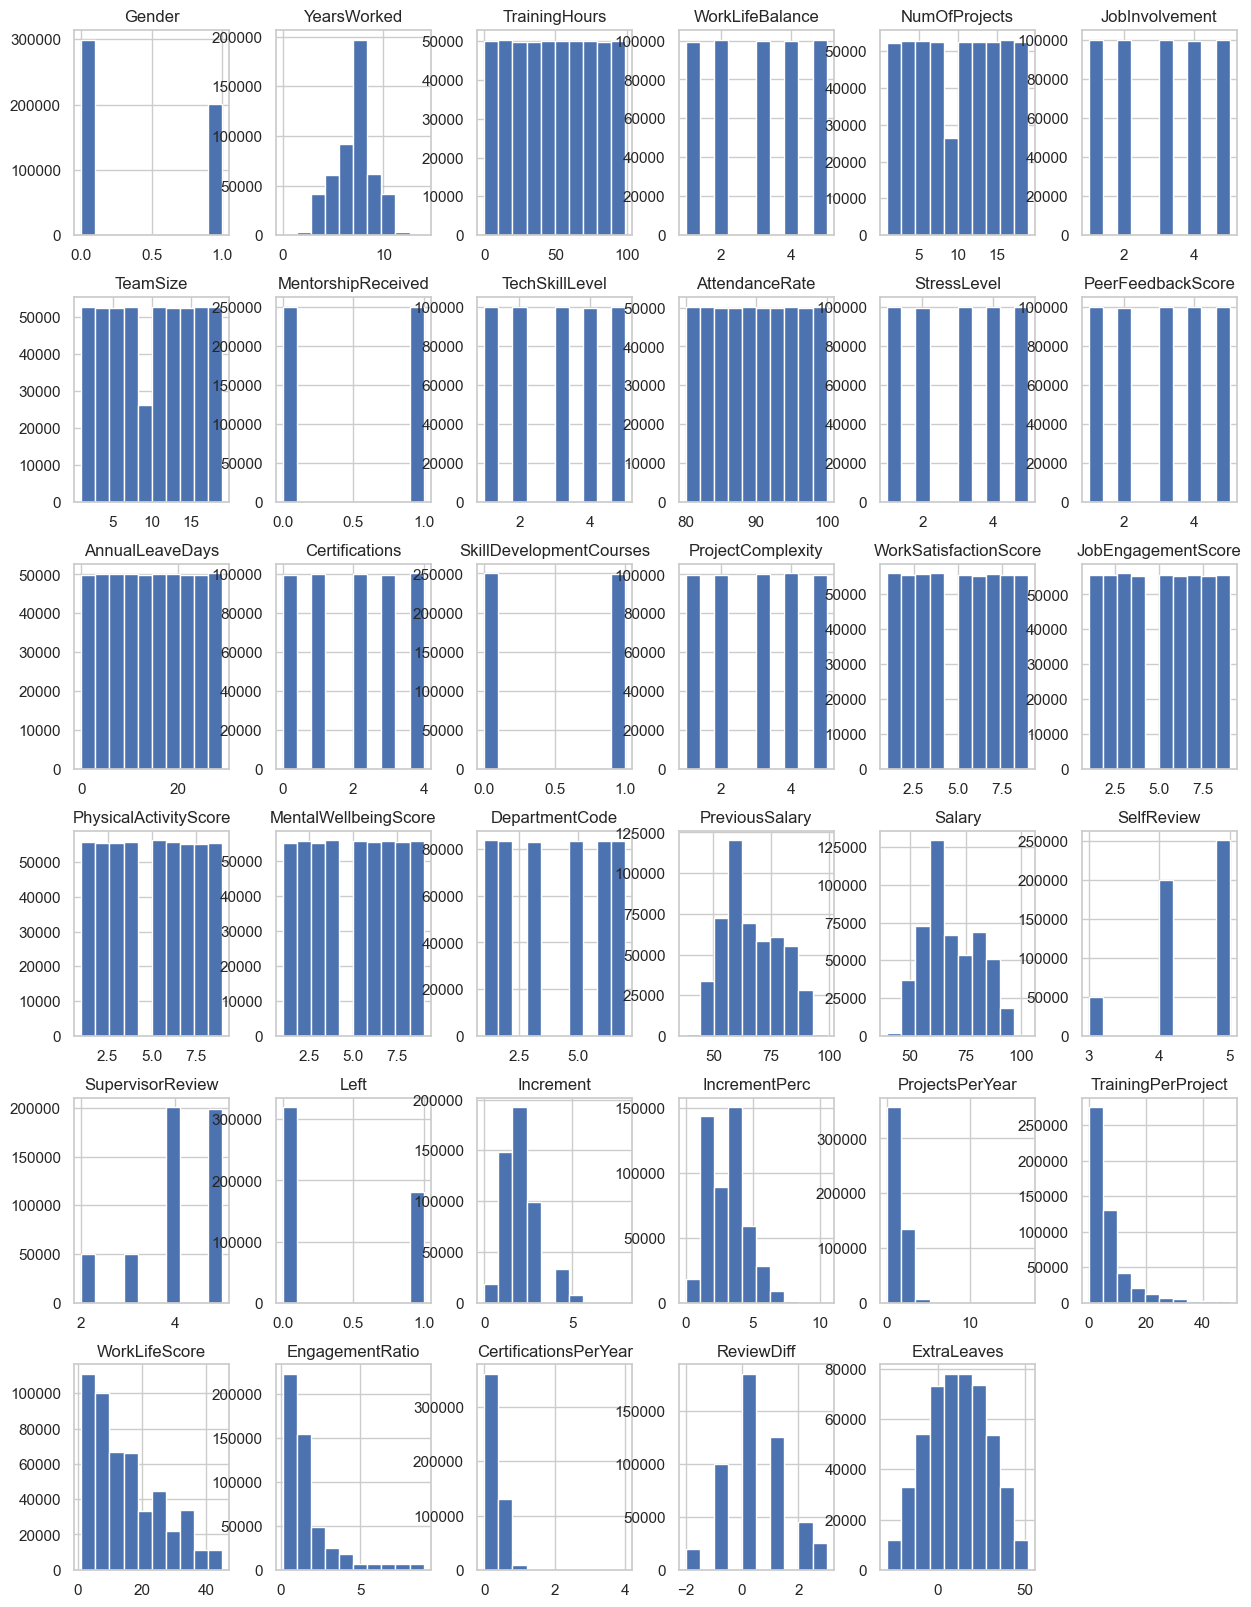

In [23]:
## 3. Distribution of Numerical Features
engineered_data.hist(figsize=(15,20))
plt.show()

In [26]:
#sns.pairplot(engineered_data, hue='Left')
#plt.show()

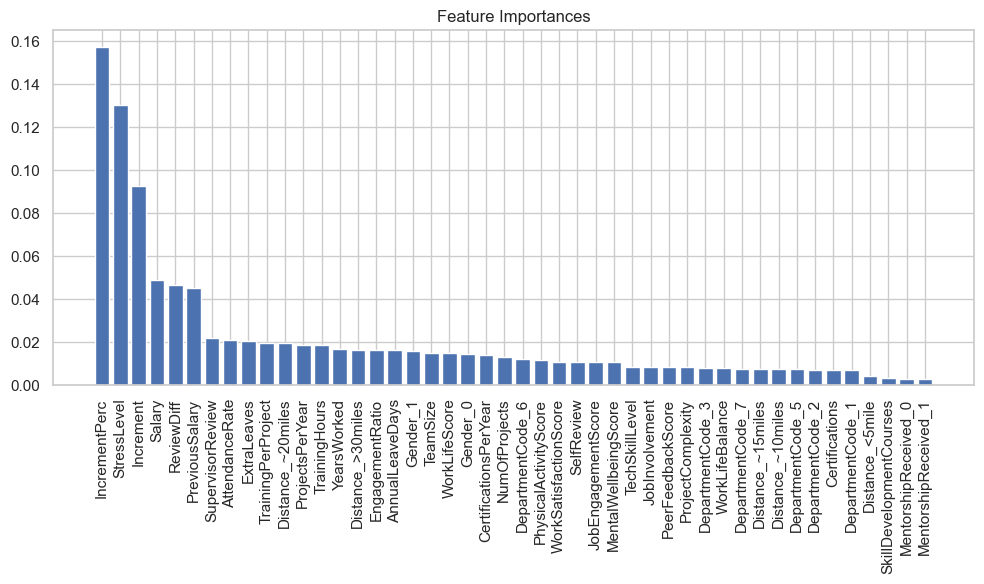

Selected features:
Index(['StressLevel', 'PreviousSalary', 'Salary', 'SupervisorReview',
       'Increment', 'IncrementPerc', 'ReviewDiff'],
      dtype='object')


In [27]:
##Random forest for feature selections
# Prepare the features and target

df = pd.get_dummies(engineered_data, columns=['Gender', 'Distance', 'DepartmentCode', 'MentorshipReceived'])

X = df.drop(['Left'], axis=1)
y = df['Left']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train the Random Forest model
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Get feature importances
importances = rf.feature_importances_
feature_names = X.columns

# Sort features by importance
indices = np.argsort(importances)[::-1]

# Select features using SelectFromModel
selector = SelectFromModel(rf, prefit=True)
X_selected = selector.transform(X)
selected_features = X.columns[selector.get_support()]

# Visualize feature importances
plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(X.shape[1]), importances[indices])
plt.xticks(range(X.shape[1]), [feature_names[i] for i in indices], rotation=90)
plt.tight_layout()
plt.show()

print("Selected features:")
print(selected_features)

In [ ]:
# Step 1: K-means Clustering
def perform_clustering(X, n_clusters=5):
    # Select numerical features for clustering
    num_features = ['StressLevel', 'PreviousSalary', 'Salary', 'SupervisorReview',
       'Increment', 'IncrementPerc', 'ReviewDiff']
    
    # Scale features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X[num_features])
    
    # Determine optimal clusters using silhouette score
    best_score = -1
    best_k = 2
    for k in range(2, 8):
        kmeans = KMeans(n_clusters=k, random_state=42)
        labels = kmeans.fit_predict(X_scaled)
        score = silhouette_score(X_scaled, labels)
        if score > best_score:
            best_score = score
            best_k = k
    
    print(f"Optimal clusters: {best_k} (silhouette score: {best_score:.3f})")
    
    # Final clustering
    kmeans = KMeans(n_clusters=best_k, random_state=42)
    X['Cluster'] = kmeans.fit_predict(X_scaled)

X_clustered = perform_clustering(X)

In [ ]:
# Prepare final dataset
final_data = engineer_features(clean_data(labeled_data.drop(columns=['Left'])))
final_data['Left'] = labeled_data['Left']

# Sanity check
print("\nFinal dataset shape:", final_data.shape)
print("Class distribution:")
print(final_data['Left'].value_counts(normalize=True))

## Model Development

In [ ]:
# Define preprocessing
numeric_features = ['YearsWorked', 'TrainingHours', 'NumOfProjects', 'TeamSize', 
                   'WorkSatisfactionScore', 'JobEngagementScore', 'SalaryIncrease',
                   'SalaryIncreasePct', 'ProjectsPerYear', 'TrainingPerProject',
                   'WorkLifeScore', 'EngagementRatio']
categorical_features = ['Distance', 'DepartmentCode']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

In [ ]:
from imblearn.pipeline import Pipeline as ImbPipeline  # Different from sklearn's Pipeline

# Update the models dictionary with imblearn pipelines
models = {
    'RandomForest': {
        'model': ImbPipeline([
            ('preprocessor', preprocessor),
            ('smote', SMOTE(random_state=42)),
            ('classifier', RandomForestClassifier(random_state=42))
        ]),
        'params': {
            'classifier__n_estimators': [100, 200],
            'classifier__max_depth': [None, 10, 20],
            'classifier__min_samples_split': [2, 5]
        }
    },
    'GradientBoosting': {
        'model': ImbPipeline([
            ('preprocessor', preprocessor),
            ('smote', SMOTE(random_state=42)),
            ('classifier', GradientBoostingClassifier(random_state=42))
        ]),
        'params': {
            'classifier__n_estimators': [100, 200],
            'classifier__learning_rate': [0.1, 0.05],
            'classifier__max_depth': [3, 5]
        }
    },
    'LogisticRegression': {
        'model': ImbPipeline([
            ('preprocessor', preprocessor),
            ('smote', SMOTE(random_state=42)),
            ('classifier', LogisticRegression(random_state=42))
        ]),
        'params': {
            'classifier__C': [0.1, 1, 10],
            'classifier__penalty': ['l2']
        }
    }
}

# The rest of your code remains the same
best_models = {}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
X = final_data.drop(columns=['Left', 'RecordId'])
y = final_data['Left']

for name, config in models.items():
    print(f"\n=== Training {name} ===")
    
    grid = GridSearchCV(
        config['model'],
        param_grid=config['params'],
        cv=cv,
        scoring='f1',
        n_jobs=-1,
        verbose=1
    )
    
    grid.fit(X, y)
    
    best_models[name] = grid.best_estimator_
    
    print(f"Best params: {grid.best_params_}")
    print(f"Best F1 score: {grid.best_score_:.4f}")
    
    y_pred = grid.best_estimator_.predict(X)
    print("\nClassification Report:")
    print(classification_report(y, y_pred))
    print("ROC AUC:", roc_auc_score(y, grid.best_estimator_.predict_proba(X)[:, 1]))

## Model Selection and Final Evaluation

In [ ]:
# Select best model based on F1 score
best_model_name = max(best_models, key=lambda x: roc_auc_score(y, best_models[x].predict_proba(X)[:, 1]))
best_model = best_models[best_model_name]
print(f"\nSelected best model: {best_model_name}")

# Save the best model
joblib.dump(best_model, 'employee_departure_model.joblib')
print("Model saved to 'employee_departure_model.joblib'")

In [ ]:
sme = SME()

In [ ]:
sme.df.head()

You can ask the expert for the label.

If he doesn't know the answer, he will freak out so ask only from the training set 
but do not ask him for every data point

In [ ]:
# e.g.
sme.ask({
    'RecordId': 101,   
})

In [ ]:
sme.ask({
    'YearsWorked': 7,
    'NumOfProjects': 14,
    'JobInvolvement': 3,
    'Distance': '~10miles'
})

# Production Notebook

Create a separate notebook that has a function similar to below.

You will receive "prod" data before the class starts. 


In [ ]:
# don't use this
from random import randint

class TestModel:
    def predict(self, X):
        return [ randint(0, 1) for _ in range(len(X))]

In [ ]:
# In the second notebook

from sklearn.metrics import classification_report

def production(X_path, y_path):
    # load model
    model = TestModel()
    
    # load data
    df_X = pd.read_csv(X_path)

    # make the changes if required 
    # -------------------------

    

    # -------------------------
    pred = model.predict(df_X)

    df_y = pd.read_csv(y_path)['Left']
    print(classification_report(df_y, pred))
    

production( 
    X_path='https://raw.githubusercontent.com/msaricaumbc/DS_data/master/ds602/final/employee_departure_dataset_X.csv',
    y_path='https://raw.githubusercontent.com/msaricaumbc/DS_data/master/ds602/final/employee_departure_dataset_y.csv'
)
    